# <font color='blue'>Data Science Academy - Machine Learning</font>

# <font color='blue'>Capítulo 13</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## Mini-Projeto 5

### Rede Neural com TensorFlow Para Classificação de Imagens de Vestuário

![title](imagens/mini-projeto5.png)

Neste Mini-Projeto vamos construir uma rede neural artificial com TensorFlow para classificação de imagens, especificamente classificação de imagens de roupas e acessórios.

Execute cada célula e acompanhe os comentários. Fique à vontade para fazer mudanças e experimentar diferentes configurações. Compare o que fazemos neste Mini-Projeto 5 com o que estudamos no Mini-Projeto 4 ao criar a rede usando apenas operações matemáticas. Aqui, usaremos o TensorFlow com o Keras.

## Instalando e Carregando os Pacotes

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [3]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

> Atenção:

Vamos criar um gráfico do modelo e para isso precisaremos de pacotes Python cujas versões disponíveis com o Anaconda não funcionam adequadamente. Sendo assim, buscaremos versões mais novas, o que requer o uso do conda.

Encerre este Jupyter Notebook, acesse o terminal ou prompt de comando e execute os comandos abaixo:

- conda install python-graphviz
- conda install pydot
- conda install pydotplus

Digite **yes** quando solicitado. Então retorne ao Jupyter Notebook.

In [4]:
# Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Configuração de gráficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Para tornar a saída deste notebook estável em todas as execuções
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Aqui definimos os diretórios onde salvaremos as imagens
PROJECT_ROOT_DIR = "."
PROJECT_NUM = "Mini-Projeto5"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "dados", PROJECT_NUM)
os.makedirs(IMAGES_PATH, exist_ok = True)

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

tensorflow       2.2.0
matplotlib       3.2.1
pandas           1.0.5
numpy            1.19.0
tensorflow.keras 2.3.0-tf
Data Science Academy


Observe que estamos usando a versão do Keras dentro do TensorFlow.

## Carregando e Preparando os Dados

Vamos começar carregando o conjunto de dados Fashion MNIST com artigos de moda masculina e feminina. O Keras possui várias funções para carregar conjuntos de dados populares no `keras.datasets`. O conjunto de dados já está dividido para você entre um conjunto de treinamento e um conjunto de testes, mas pode ser útil dividir ainda mais o conjunto de treinamento para ter um conjunto de validação.

In [7]:
# Carrega o dataset
fashion_mnist = keras.datasets.fashion_mnist

In [8]:
# Extraímos os dados de treino e de teste
(X_treino_full, y_treino_full), (X_teste, y_teste) = fashion_mnist.load_data()

O conjunto de treinamento contém 60.000 imagens em escala de cinza, cada uma com 28x28 pixels:

In [9]:
# Shape
X_treino_full.shape

(60000, 28, 28)

Cada intensidade de pixel é representada como um byte (0 a 255):

In [10]:
# Tipo de dados
X_treino_full.dtype

dtype('uint8')

Vamos dividir o conjunto de treinamento completo em um conjunto de validação e um conjunto de treinamento (menor). Também dimensionamos as intensidades de pixel para o intervalo de 0-1 (padronização) e as convertemos em float, dividindo por 255.

In [11]:
# Preparação dos dados
X_valid, X_treino = X_treino_full[:5000] / 255., X_treino_full[5000:] / 255.
y_valid, y_treino = y_treino_full[:5000], y_treino_full[5000:]
X_teste = X_teste / 255.

Você pode plotar uma imagem usando a função `imshow ()` do Matplotlib, com um mapa de cores **binary**.

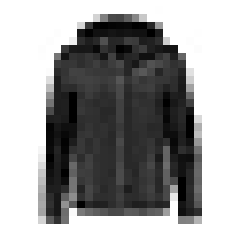

In [12]:
# Plot de uma imagem
plt.imshow(X_treino[0], cmap = "binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como uint8), de 0 a 9:

In [13]:
# Labels (dados de saída) de treino
y_treino

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Aqui estão os nomes de classe correspondentes:

In [14]:
# Nomes das classes
nomes_classes = ["T-shirt/top", 
                 "Trouser", 
                 "Pullover", 
                 "Dress", 
                 "Coat", 
                 "Sandal", 
                 "Shirt", 
                 "Sneaker", 
                 "Bag", 
                 "Ankle boot"]

Mais detalhes do dataset aqui: https://www.tensorflow.org/datasets/catalog/fashion_mnist

Portanto, a primeira imagem no conjunto de treinamento é um casaco:

In [15]:
# Nome de classe
nomes_classes[y_treino[0]]

'Coat'

O conjunto de validação contém 5.000 imagens e o conjunto de testes contém 10.000 imagens:

In [16]:
# Shape
X_valid.shape

(5000, 28, 28)

In [17]:
# Shape
X_teste.shape

(10000, 28, 28)

Vamos dar uma olhada em uma amostra das imagens no conjunto de dados.

In [18]:
# Função para salvar as imagens
def salva_imagem(fig_id, tight_layout = True, fig_extension = "png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Salvando a imagem...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)

Salvando a imagem... plot_fashion_mnist


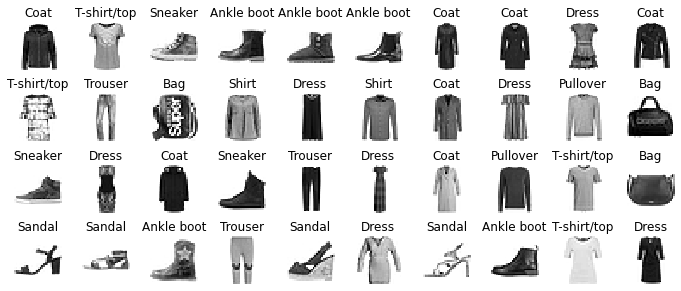

In [19]:
# Plot de algumas imagens

# Vamos plotar 4 linhas e 10 coluns
n_rows = 4
n_cols = 10

# Área de plotagem
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

# Loop pelas linhas e colunas
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_treino[index], cmap = "binary", interpolation = "nearest")
        plt.axis('off')
        plt.title(nomes_classes[y_treino[index]], fontsize = 12)

# Ajusta os plots
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

# Salva a imagem em disco
salva_imagem('plot_fashion_mnist', tight_layout = False)

# Mostra a imagem
plt.show()

Perfeito! Os dados estão prontos. Vamos construir e treinar o modelo.

## Construção do Modelo

In [20]:
# Modelo de Rede Neural com 2 Camadas Densas

# Cria o objeto do tipo sequência
modelo = keras.models.Sequential()

# Camada para receber os dados de entrada
modelo.add(keras.layers.Flatten(input_shape = [28, 28]))

# Primeira camada oculta com ativação relu
modelo.add(keras.layers.Dense(300, activation = "relu"))

# Segunda camada oculta com ativação relu
modelo.add(keras.layers.Dense(100, activation = "relu"))

# Camada de saída com ativação softmax
# Teremos uma probabilidade prevista para cada classe
modelo.add(keras.layers.Dense(10, activation = "softmax"))

In [21]:
# Limpamos a sessão Keras e 
keras.backend.clear_session()

In [22]:
# Camadas do modelo
modelo.layers

In [23]:
# Sumário do modelo
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


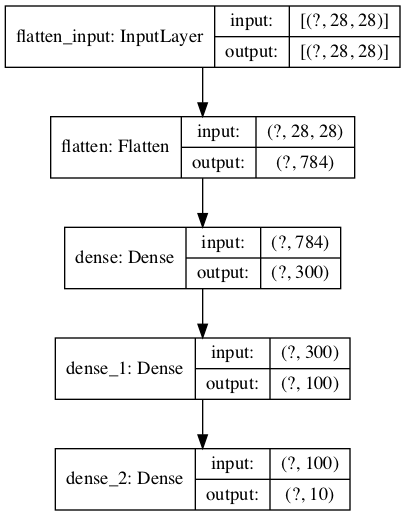

In [24]:
# Vamos criar um plot com o modelo completo e salvar a imagem em disco
keras.utils.plot_model(modelo, IMAGES_PATH + "/modelo_fashion_mnist.png", show_shapes = True)

In [25]:
# Vamos nomear a primeira camada oculta do modelo
hidden1 = modelo.layers[1]
hidden1.name

'dense'

In [26]:
# Verificamos se a camada com novo nome existe
modelo.get_layer(hidden1.name) is hidden1

True

In [27]:
# Extraímos pesos e bias da primeira camada oculta
weights, biases = hidden1.get_weights()

In [28]:
# Pesos que serão usados no começo do treinamento e são gerados de forma aleatória pelo Keras/TensorFlow
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [29]:
# Shape
weights.shape

(784, 300)

In [30]:
# Bias que serão usados no começo do treinamento
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
# Shape
biases.shape

(300,)

In [32]:
# Agora compilamos o modelo com o otimizador, função de custo e a métrica
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy
modelo.compile(optimizer = "sgd", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Podemos então treinar o modelo.

In [33]:
# Treinamento
history = modelo.fit(X_treino, 
                     y_treino, 
                     epochs = 50, 
                     validation_data = (X_valid, y_valid))

Epoch 1/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/50
1719/1719 [==============================] - 2s 971us/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/50
1719/1719 [==============================] - 2s 952us/step - loss: 0.4392 - accuracy: 0.8455 - val_loss: 0.5334 - val_accuracy: 0.7982
Epoch 4/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4124 - accuracy: 0.8567 - val_loss: 0.3916 - val_accuracy: 0.8652
Epoch 5/50
1719/1719 [==============================] - 2s 958us/step - loss: 0.3939 - accuracy: 0.8619 - val_loss: 0.3750 - val_accuracy: 0.8686
Epoch 6/50
1719/1719 [==============================] - 2s 958us/step - loss: 0.3752 - accuracy: 0.8673 - val_loss: 0.3709 - val_accuracy: 0.8718
Epoch 7/50
1719/1719 [==============================] - 2s 950us/step - loss: 0.3633 - accuracy: 0.8715 - val_loss: 0.3618 - val

In [34]:
# Hiperparâmetros do modelo
history.params

{'verbose': 1, 'epochs': 50, 'steps': 1719}

In [35]:
# Aqui estão as métricas disponíveis após o treinamento (erro e acurácia)
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Salvando a imagem... plot_keras_learning_curves


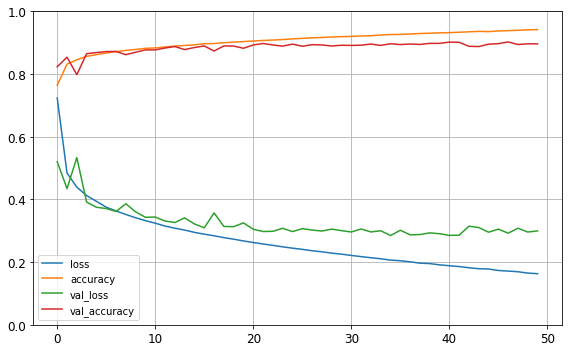

In [36]:
# Colocamos o histórico de treinamento em um dataframe, plotamos e salvamos a figura
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
salva_imagem("plot_keras_learning_curves")
plt.show()

## Avaliando o Modelo

Você já conhece o ritual. Depois de treinar, testamos o modelo com dados de teste.

In [37]:
# Avalia o modelo
modelo.evaluate(X_teste, y_teste)

313/313 [==============================] - 0s 722us/step - loss: 0.3342 - accuracy: 0.8870


[0.3341985046863556, 0.8870000243186951]

Conseguimos mais de 88% de acurácia em teste. Vamos fazer a previsão de algumas imagens.

In [38]:
# Vamos extrair 5 imagens de teste
X_new = X_teste[:5]

In [39]:
# E então prever a probabilidade de cada classe para cada imagem
y_proba = modelo.predict(X_new)

In [40]:
# Previsões de probabilidade
y_proba

array([[1.6294470e-07, 3.6253882e-09, 1.2579389e-05, 1.6609062e-06,
        9.1626504e-08, 3.7001824e-04, 3.5667594e-07, 2.7769979e-03,
        1.2492963e-05, 9.9682570e-01],
       [4.3675071e-05, 4.4733114e-10, 9.9926728e-01, 3.8461594e-09,
        6.5115863e-04, 2.6769021e-12, 3.7911195e-05, 2.9771508e-11,
        3.3769032e-10, 3.7565415e-12],
       [1.6622193e-08, 1.0000000e+00, 7.1750092e-11, 2.1921718e-08,
        6.3398455e-09, 6.0851474e-15, 4.2657271e-12, 1.5100399e-15,
        3.7022319e-10, 3.4262824e-15],
       [2.8740137e-08, 9.9999809e-01, 4.1640952e-10, 1.8789664e-06,
        2.5832906e-08, 1.4342712e-11, 9.6161239e-11, 2.7907025e-14,
        1.9973985e-10, 1.8774730e-11],
       [4.0516770e-01, 7.8377536e-07, 7.5198752e-03, 4.9693743e-04,
        9.1814180e-04, 9.6045820e-09, 5.8589375e-01, 2.5862144e-07,
        1.8393348e-06, 6.6949576e-07]], dtype=float32)

In [41]:
# As previsões de classes são mais fáceis de interpretar
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.41, 0.  , 0.01, 0.  , 0.  , 0.  , 0.59, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [42]:
# Vamos gravar as previsões das 5 imagens
y_pred = modelo.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1, 1, 6])

In [43]:
# E então extraímos os nomes das classes associados a cada previsão
np.array(nomes_classes)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt'],
      dtype='<U11')

Vamos plotar as previsões.

Salvando a imagem... plot_previsoes_fashion_mnist_images


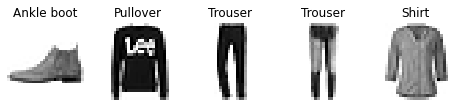

In [44]:
# Plot
plt.figure(figsize = (8, 5))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap = "binary", interpolation = "nearest")
    plt.axis('off')
    plt.title(nomes_classes[y_teste[index]], fontsize = 12)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
salva_imagem('plot_previsoes_fashion_mnist_images', tight_layout = False)
plt.show()

Previsões feitas com sucesso!

# Fim